In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_sigmoid_stack = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward_propagation(self, x):
        N = self.linear_sigmoid_stack(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

## Example 1
### Differential equation
$$\frac{d\psi}{dx} + \left(x+\frac{1+3x^2}{1+x+x^3} \right)\psi = x^3+2x+x^2\left(\frac{1+3x^2}{1+x+x^3} \right)$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\psi_t(x) = A + xN(x,\vec{p})$, with $\psi(0) = A = 1$ initial condition.  

In [5]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [6]:
optimizer = torch.optim.LBFGS(model.parameters())
A = 1
Psi_t = lambda x: A + x * model.forward_propagation(x)
f = lambda x, Psi: x**3 + 2*x + ((1+3*x**2)/(1+x+x**3))*x**2 - (x+(1+3*x**2)/(1+x+x**3))*Psi

In [7]:
def loss_fn(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs))**2)

In [8]:
upper_x = 20
steps = 100
X_train = torch.Tensor(np.linspace(0,upper_x,steps)[:,None])
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(X_train.to(device))}")
    training(X_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: 9972995.0
Epoch 2
 ---------------------- loss: 277035.0
Epoch 3
 ---------------------- loss: 9494.564453125
Epoch 4
 ---------------------- loss: 2564.79248046875
Epoch 5
 ---------------------- loss: 348.20123291015625
Epoch 6
 ---------------------- loss: 664.9927978515625
Epoch 7
 ---------------------- loss: 68.93655395507812
Epoch 8
 ---------------------- loss: 55.011268615722656
Epoch 9
 ---------------------- loss: 31.312496185302734
Epoch 10
 ---------------------- loss: 24.84556007385254
Epoch 11
 ---------------------- loss: 14.991609573364258
Epoch 12
 ---------------------- loss: 15.801640510559082
Epoch 13
 ---------------------- loss: 9.247840881347656
Epoch 14
 ---------------------- loss: 7999.60986328125
Epoch 15
 ---------------------- loss: 7.993539810180664
Epoch 16
 ---------------------- loss: 7.055448055267334
Epoch 17
 ---------------------- loss: 6.006043434143066
Epoch 18
 ---------------------- loss: 5.473936557769775


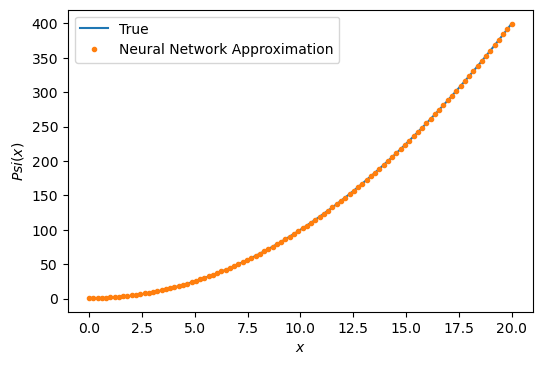

In [9]:
xx = np.linspace(0, upper_x, steps)[:,None]

with torch.no_grad():
    sol = Psi_t(torch.Tensor(xx).to(device)).cpu()
    yy = sol.numpy()
yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
axs.plot(xx, yt, label="True")
axs.plot(xx, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$Psi(x)$")
plt.legend(loc="best")

In [10]:
score = r2_score(yt, yy)
print(score)
error = yt - yy
print(error)

0.9999959431715931
[[ 0.        ]
 [-0.14433807]
 [-0.29441381]
 [-0.42843886]
 [-0.53698897]
 [-0.61130927]
 [-0.65215934]
 [-0.66625703]
 [-0.66167085]
 [-0.64510356]
 [-0.62143771]
 [-0.59393243]
 [-0.56451814]
 [-0.53443554]
 [-0.50437694]
 [-0.47464295]
 [-0.44550902]
 [-0.4170952 ]
 [-0.38938855]
 [-0.3625052 ]
 [-0.33644328]
 [-0.31122415]
 [-0.28676326]
 [-0.26316456]
 [-0.24051614]
 [-0.21853397]
 [-0.19752708]
 [-0.17735054]
 [-0.15796621]
 [-0.139458  ]
 [-0.12184501]
 [-0.10503567]
 [-0.08912535]
 [-0.07402632]
 [-0.05973857]
 [-0.0462621 ]
 [-0.03365414]
 [-0.02191087]
 [-0.01092929]
 [-0.00069796]
 [ 0.00878694]
 [ 0.01733848]
 [ 0.02539917]
 [ 0.03238918]
 [ 0.03884257]
 [ 0.04450755]
 [ 0.04965118]
 [ 0.05394537]
 [ 0.05765716]
 [ 0.06060344]
 [ 0.06292154]
 [ 0.06486323]
 [ 0.0659555 ]
 [ 0.06662558]
 [ 0.06686584]
 [ 0.06638638]
 [ 0.06550761]
 [ 0.06424481]
 [ 0.06237672]
 [ 0.06025429]
 [ 0.05780123]
 [ 0.05504806]
 [ 0.05191847]
 [ 0.04830567]
 [ 0.04475896]
 [ 0.0

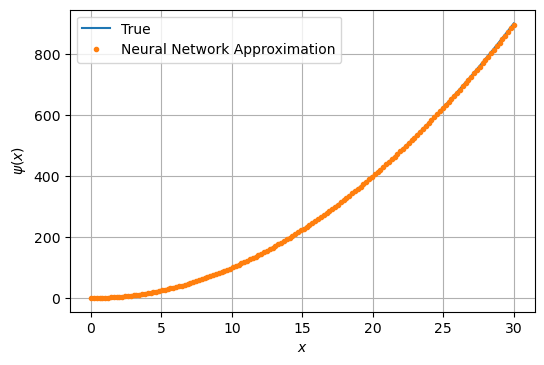

In [11]:
xxx = np.linspace(0, int(upper_x*1.5), int(steps*1.5))[:,None]
with torch.no_grad():
    yyy = Psi_t(torch.Tensor(xxx).to(device)).cpu().numpy()
yyt = xxx**2 + np.exp(-xxx**2 / 2)/(1+xxx+xxx**3)

fig, axs = plt.subplots(dpi=100)
axs.plot(xxx, yyt, label="True")
axs.plot(xxx, yyy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [12]:
score = r2_score(yyt, yyy)
print(score)
error = yyt - yyy
print(error)

0.999980856783291
[[ 0.00000000e+00]
 [-1.43803027e-01]
 [-2.93459417e-01]
 [-4.27192357e-01]
 [-5.35755433e-01]
 [-6.10347596e-01]
 [-6.51610006e-01]
 [-6.66187920e-01]
 [-6.61955971e-01]
 [-6.45698997e-01]
 [-6.22302532e-01]
 [-5.94979561e-01]
 [-5.65740849e-01]
 [-5.35768536e-01]
 [-5.05775725e-01]
 [-4.76112367e-01]
 [-4.47085728e-01]
 [-4.18645801e-01]
 [-3.91059594e-01]
 [-3.64213298e-01]
 [-3.38152201e-01]
 [-3.12956071e-01]
 [-2.88542378e-01]
 [-2.64988401e-01]
 [-2.42237319e-01]
 [-2.20365580e-01]
 [-1.99312209e-01]
 [-1.79119188e-01]
 [-1.59797969e-01]
 [-1.41270352e-01]
 [-1.23624077e-01]
 [-1.06824811e-01]
 [-9.07771872e-02]
 [-7.56261640e-02]
 [-6.13908149e-02]
 [-4.79032931e-02]
 [-3.51712282e-02]
 [-2.32442111e-02]
 [-1.21756477e-02]
 [-1.91594678e-03]
 [ 7.54252095e-03]
 [ 1.63065670e-02]
 [ 2.42770094e-02]
 [ 3.14538479e-02]
 [ 3.79515236e-02]
 [ 4.38005540e-02]
 [ 4.90085685e-02]
 [ 5.32780208e-02]
 [ 5.69827512e-02]
 [ 6.01303890e-02]
 [ 6.25988639e-02]
 [ 6.45178757

## Example 3
### Differential equation
$$\frac{d^2\psi}{dx^2} + \frac{1}{5}\frac{d\psi}{dx} + \psi= -\frac{1}{5}e^{-\frac{x}{5}}\cos{(x)}$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\psi_t(x) = A + Bx + x^2N(x,\vec{p})$, with $\psi(0) = A = 0$ and $\frac{d\psi}{dx}|_0 = 1$ initial conditions.

In [18]:
model_1= NeuralNetwork().to(device)
model_1

NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [19]:
optimizer = torch.optim.LBFGS(model_1.parameters())
A = 0
B = 1
Psi_t = lambda x: A + B*x + (x**2) * model_1.forward_propagation(x)
f = lambda x, Psi, Psi_x: -(1/5)*torch.exp(-x/5)*torch.cos(x) - Psi - (1/5)*Psi_x

In [20]:
def loss_fn_1(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x), create_graph=True)[0]
    return torch.mean((Psi_t_x_x- f(x, outputs, Psi_t_x))**2)

In [21]:
upper_x_1 = 5
steps_1 = 100
X_train_1 = torch.Tensor(np.linspace(0,upper_x_1,steps_1)[:,None])
epochs_1 = 50
for t in range(epochs_1):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn_1(X_train_1.to(device))}")
    training(X_train_1, loss_fn_1, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: 3.465226411819458
Epoch 2
 ---------------------- loss: 0.009653517045080662
Epoch 3
 ---------------------- loss: 0.0019235926447436213
Epoch 4
 ---------------------- loss: 0.0005673114210367203
Epoch 5
 ---------------------- loss: 0.0003194934397470206
Epoch 6
 ---------------------- loss: 0.00035747207584790885
Epoch 7
 ---------------------- loss: 0.00014316751912701875
Epoch 8
 ---------------------- loss: 0.00012123602209612727
Epoch 9
 ---------------------- loss: 7.657187961740419e-05
Epoch 10
 ---------------------- loss: 6.505013152491301e-05
Epoch 11
 ---------------------- loss: 6.283117545535788e-05
Epoch 12
 ---------------------- loss: 0.0005035278736613691
Epoch 13
 ---------------------- loss: 5.270923429634422e-05
Epoch 14
 ---------------------- loss: 5.170557415112853e-05
Epoch 15
 ---------------------- loss: 4.785980127053335e-05
Epoch 16
 ---------------------- loss: 4.4293017708696425e-05
Epoch 17
 ---------------------- l

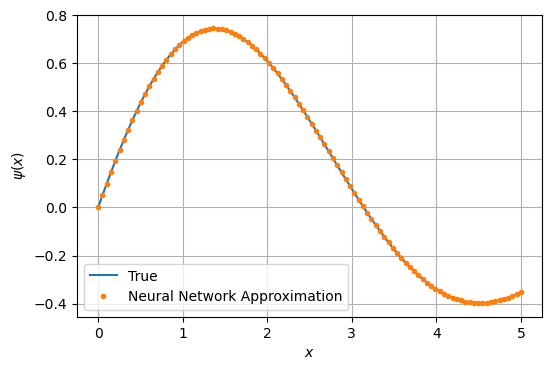

In [27]:
xx = np.linspace(0, upper_x_1, steps_1)[:,None]

with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx).to(device)).cpu().numpy()
yt = yt = np.exp(-xx / 5)*np.sin(xx)

fig, axs = plt.subplots(dpi=100)
axs.plot(xx, yt, label="True")
axs.plot(xx, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [23]:
score = r2_score(yt, yy)
print(score)
error = yt - yy
print(error)

0.999999984500435
[[ 0.00000000e+00]
 [ 1.27681331e-06]
 [ 4.25206534e-06]
 [ 7.85587244e-06]
 [ 1.12958192e-05]
 [ 1.39709275e-05]
 [ 1.55095854e-05]
 [ 1.56669263e-05]
 [ 1.44132475e-05]
 [ 1.16622016e-05]
 [ 7.66706926e-06]
 [ 2.38654530e-06]
 [-3.73595923e-06]
 [-1.06488897e-05]
 [-1.79762525e-05]
 [-2.57777649e-05]
 [-3.33876226e-05]
 [-4.08316392e-05]
 [-4.78751445e-05]
 [-5.43966685e-05]
 [-6.02391792e-05]
 [-6.51344065e-05]
 [-6.89977333e-05]
 [-7.18778360e-05]
 [-7.41565346e-05]
 [-7.52101107e-05]
 [-7.49422139e-05]
 [-7.38961874e-05]
 [-7.17077424e-05]
 [-6.88445070e-05]
 [-6.50752667e-05]
 [-6.01518463e-05]
 [-5.50936244e-05]
 [-4.88883873e-05]
 [-4.24701598e-05]
 [-3.57278124e-05]
 [-2.85110123e-05]
 [-2.15201154e-05]
 [-1.39202742e-05]
 [-6.44097355e-06]
 [ 7.68503666e-07]
 [ 7.66051999e-06]
 [ 1.35722622e-05]
 [ 1.98475612e-05]
 [ 2.48307100e-05]
 [ 2.87566433e-05]
 [ 3.29216398e-05]
 [ 3.46848295e-05]
 [ 3.76129531e-05]
 [ 3.75490373e-05]
 [ 3.72959925e-05]
 [ 3.63906387

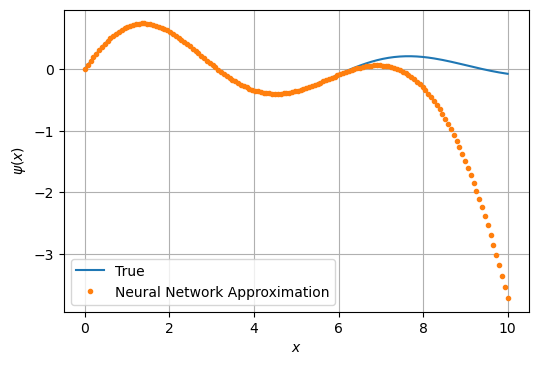

In [26]:
xxx = np.linspace(0,int(upper_x_1*2),int(steps_1*1.5))[:,None]

with torch.no_grad():
    yyy = Psi_t(torch.Tensor(xxx).to(device)).cpu().numpy()
yyt = np.exp(-xxx / 5)*np.sin(xxx)

fig, axs = plt.subplots(dpi=100)
axs.plot(xxx, yyt, label="True")
axs.plot(xxx, yyy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [25]:
score = r2_score(yyt, yyy)
print(score)
error = yyt - yyy
print(error)

-6.746590084560874
[[ 0.00000000e+00]
 [ 2.12291015e-06]
 [ 6.60309762e-06]
 [ 1.12418223e-05]
 [ 1.45977770e-05]
 [ 1.57544488e-05]
 [ 1.44226735e-05]
 [ 1.05740229e-05]
 [ 4.47003800e-06]
 [-3.43307119e-06]
 [-1.27920896e-05]
 [-2.28219824e-05]
 [-3.28730258e-05]
 [-4.28259009e-05]
 [-5.19010362e-05]
 [-5.96935827e-05]
 [-6.62117795e-05]
 [-7.07956500e-05]
 [-7.40842714e-05]
 [-7.50999088e-05]
 [-7.44117971e-05]
 [-7.18712440e-05]
 [-6.78539911e-05]
 [-6.18656868e-05]
 [-5.55984787e-05]
 [-4.77379323e-05]
 [-3.86946602e-05]
 [-2.92815758e-05]
 [-2.03054932e-05]
 [-9.67062219e-06]
 [-5.78895848e-07]
 [ 8.92042720e-06]
 [ 1.70684657e-05]
 [ 2.42009864e-05]
 [ 2.93818606e-05]
 [ 3.39632798e-05]
 [ 3.69372969e-05]
 [ 3.87719516e-05]
 [ 3.63311841e-05]
 [ 3.41544490e-05]
 [ 2.94224295e-05]
 [ 2.23487702e-05]
 [ 1.42113329e-05]
 [ 4.23125024e-06]
 [-5.16113353e-06]
 [-1.63674345e-05]
 [-2.79269431e-05]
 [-3.84107967e-05]
 [-4.88366091e-05]
 [-5.69267915e-05]
 [-6.53827063e-05]
 [-6.9126593